# Thesis random sweeps - 1Try - Fisher Info and characterisation plots


1/2

Vary most parameters randomly, checking usual metrics when no data is available.

Will need to filter and plot parameter effects afterwards.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [380]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [381]:
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fisher2016_random_large_300816.py

In [451]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]

def process_fi(array_name, array):
    outputs = avg_twice_lastaxis(array_name, array)
    outputs.extend(avg_twice_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs

def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    outputs_all = avg_lastaxis(array_name, array)
    
    if array_name.find('inv') > -1:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2.*array)**0.5))
    else:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    
    outputs = [(o[0], o[1][:, 0]) for o in outputs_all]
    return outputs

def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    outputs.append((array_name + '_stddev', utils.kappa_to_stddev(emfits_all[:, 0])))
    
    return outputs

    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [452]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

T_space = data_pbs.loaded_data['parameters_uniques']['T']
M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
sigmabase_space = data_pbs.loaded_data['parameters_uniques']['sigma_baseline']

pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=avg_lastaxis)),
    ('result_FI_rc_curv', dict(name='fi_curv', process=process_fi)),
    ('result_FI_rc_theo', dict(name='fi_theo', process=process_fi)),
    ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=process_fi)),
    ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
    ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('T')] = df_all_fits.loc[:, ('T')].astype(int)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

In [453]:
df_all_fits.describe()

,precision,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,inv_fi_marginal,...,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,M,ratio_conj,sigmax,sigma_baseline
count,19504.000000,19504.000000,19504.000000,19504.000000,19504.000000,19504.000000,19504.000000,19504.000000,19504.000000,1.950400e+04,...,1.950400e+04,19504.000000,19504.000000,1.950400e+04,19504.000000,19504.000000,19504.000000,19504.000000,19504.000000,19504.000000
mean,27.940973,603.759716,0.357120,430.768193,0.979887,430.285977,0.983829,443.824736,0.632646,-4.732163e+17,...,3.316785e-01,-223.337933,473.181851,7.204365e+02,0.286911,3.002717,205.347518,0.464602,0.366381,0.363057
std,668.420644,2413.668493,0.837257,2460.624392,12.448792,2539.074313,12.451886,2534.771083,3.254589,6.681699e+19,...,2.663941e-01,162.853751,328.516600,3.068025e+04,0.274222,1.413866,165.972917,0.288393,0.201326,0.200897
min,0.125789,0.017295,0.003600,0.000197,0.003400,0.000198,0.003400,0.000201,0.003337,-9.330141e+21,...,5.082966e-12,-367.542292,-1509.338355,1.651269e-01,0.000491,1.000000,4.000000,0.000000,0.010303,0.010107
25%,0.293378,15.485214,0.077337,8.711799,0.098063,8.589513,0.098771,8.844827,0.096736,4.672171e-03,...,9.797217e-02,-333.007160,376.554952,6.341597e+00,0.084373,2.000000,80.000000,0.209989,0.195547,0.192067
50%,0.478881,73.006560,0.179402,39.674973,0.224563,39.162769,0.226012,40.504718,0.222214,2.526297e-02,...,2.756626e-01,-283.712723,594.618482,2.424731e+01,0.203080,3.000000,149.000000,0.450704,0.359377,0.354986
75%,1.008036,388.710494,0.393320,208.054302,0.479370,205.205361,0.482620,213.746103,0.475525,1.234000e-01,...,5.329102e-01,-176.171055,695.143583,1.404745e+02,0.397101,4.000000,312.000000,0.710673,0.520668,0.519938
max,72519.400615,155780.291007,22.317188,173425.178388,880.358157,173425.178388,882.309039,179621.938818,99.793590,1.278326e+20,...,9.970579e-01,762.616653,771.971883,4.150182e+06,2.460884,5.000000,623.000000,1.000000,0.799937,0.799892


In [454]:
# Remove outliers
df_fits_filtered = df_all_fits[np.all(np.abs(spst.zscore(df_all_fits)) < 7, axis=1)]

In [455]:
df_fits_filtered.describe()

,precision,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,inv_fi_marginal,...,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,M,ratio_conj,sigmax,sigma_baseline
count,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,1.933300e+04,...,1.933300e+04,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000,19333.000000
mean,12.762058,517.677138,0.305582,339.305668,0.419976,336.201734,0.423810,349.733272,0.417594,2.827577e+13,...,3.298824e-01,-224.855436,476.227397,354.920224,0.288321,3.004707,205.603062,0.464897,0.367133,0.363988
std,141.784109,1273.962718,0.400347,1043.453106,0.815361,1039.550658,0.819265,1077.249320,0.770631,8.763929e+15,...,2.639784e-01,157.475945,317.806542,3399.120771,0.273397,1.413163,165.192274,0.288109,0.201099,0.200734
min,0.125789,0.073466,0.010873,0.003570,0.010894,0.003570,0.010868,0.003676,0.010737,-4.121920e+17,...,2.021097e-11,-367.542292,-1169.180251,0.222739,0.002225,1.000000,4.000000,0.000000,0.010303,0.010107
25%,0.295386,15.827813,0.077621,8.933585,0.098516,8.775303,0.099169,9.049531,0.097179,4.757982e-03,...,9.852782e-02,-332.578703,378.153314,6.301071,0.085953,2.000000,81.000000,0.210390,0.196909,0.193388
50%,0.480744,73.761767,0.178698,39.974090,0.223722,39.433486,0.225255,40.776263,0.221469,2.527398e-02,...,2.743168e-01,-283.234310,594.052605,23.727949,0.205291,3.000000,149.000000,0.450704,0.360093,0.356401
75%,1.009544,386.318746,0.388692,206.125107,0.473199,203.611312,0.477639,211.807297,0.470148,1.215987e-01,...,5.301362e-01,-176.895263,694.210231,135.356028,0.398376,4.000000,311.000000,0.711111,0.520968,0.520552
max,4668.323094,17247.261412,6.157060,16879.676903,24.941423,16968.088925,24.918817,17350.032466,23.326204,9.627467e+17,...,9.961011e-01,595.186760,771.238743,202040.387116,2.118858,5.000000,623.000000,1.000000,0.799937,0.799892


## -> Some stats

In [456]:
## Correlations
df_fits_filtered.corr()

,precision,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,inv_fi_marginal,...,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,T,M,ratio_conj,sigmax,sigma_baseline
precision,1.000000,0.240486,-0.057390,0.306692,-0.040520,0.308146,-0.040735,0.305014,-0.042647,-0.000286,...,-0.107403,0.344691,-0.344395,0.038342,-0.077702,-0.118855,0.046593,-0.012792,-0.101755,-0.100101
fi_curv,0.240486,1.000000,-0.265227,0.968771,-0.181457,0.966874,-0.182270,0.968951,-0.191150,-0.001311,...,0.128334,0.404482,-0.402360,0.186351,-0.354427,-0.064140,0.501449,-0.313033,-0.136167,-0.069296
fi_curv_stddev,-0.057390,-0.265227,1.000000,-0.215273,0.917917,-0.214174,0.919535,-0.215036,0.942865,0.032364,...,-0.184241,-0.318148,0.317246,0.032955,0.722702,0.083024,-0.463345,0.251836,0.073939,0.001092
fi_theo,0.306692,0.968771,-0.215273,1.000000,-0.148237,0.999772,-0.148926,0.999943,-0.156119,-0.001049,...,-0.007838,0.494453,-0.492232,0.171350,-0.289603,-0.094249,0.395674,-0.240534,-0.188610,-0.113016
fi_theo_stddev,-0.040520,-0.181457,0.917917,-0.148237,1.000000,-0.147497,0.999953,-0.148058,0.978678,0.041851,...,-0.052666,-0.256021,0.255823,0.048268,0.485096,0.089221,-0.331591,0.137684,0.081662,0.006663
fi_theo_cov,0.308146,0.966874,-0.214174,0.999772,-0.147497,1.000000,-0.148186,0.999702,-0.155340,-0.001044,...,-0.009734,0.495996,-0.493804,0.171338,-0.288174,-0.096032,0.392642,-0.239035,-0.189572,-0.111728
fi_theo_cov_stddev,-0.040735,-0.182270,0.919535,-0.148926,0.999953,-0.148186,1.000000,-0.148746,0.979112,0.041797,...,-0.054058,-0.257666,0.257546,0.048064,0.487884,0.093132,-0.332874,0.138061,0.081715,0.005972
fi_marginal,0.305014,0.968951,-0.215036,0.999943,-0.148058,0.999702,-0.148746,1.000000,-0.155934,-0.001048,...,-0.007294,0.493324,-0.491105,0.171415,-0.289322,-0.093905,0.395559,-0.240899,-0.188182,-0.112644
fi_marginal_stddev,-0.042647,-0.191150,0.942865,-0.156119,0.978678,-0.155340,0.979112,-0.155934,1.000000,0.044861,...,-0.060148,-0.269744,0.269580,0.055372,0.517239,0.095897,-0.349215,0.144934,0.092182,0.011047
inv_fi_marginal,-0.000286,-0.001311,0.032364,-0.001049,0.041851,-0.001044,0.041797,-0.001048,0.044861,1.000000,...,0.002857,-0.003006,0.002998,-0.007600,-0.008251,0.000837,-0.003846,0.003492,0.000969,0.005348


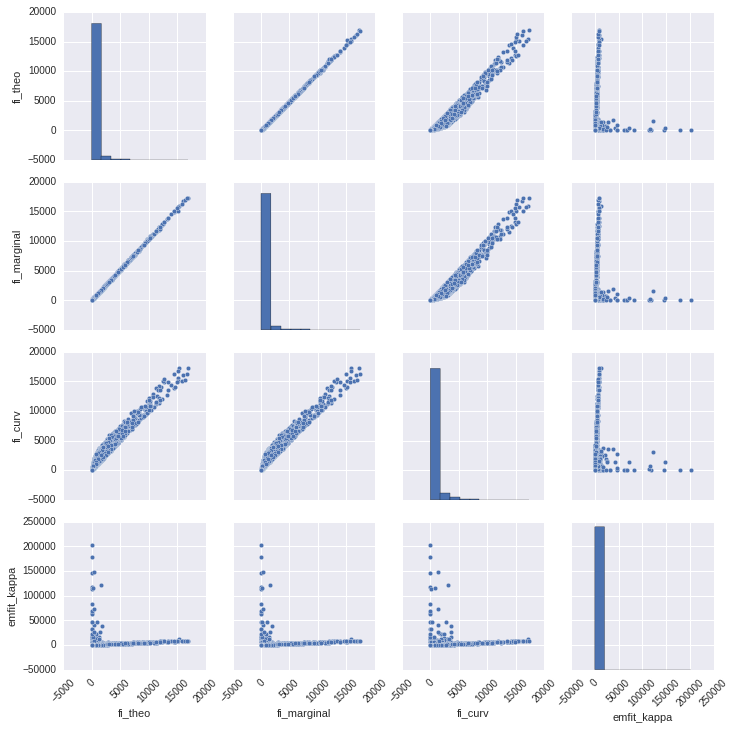

In [457]:
# Cross-correlation plots
g = sns.pairplot(df_fits_filtered,
             x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
            )
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)


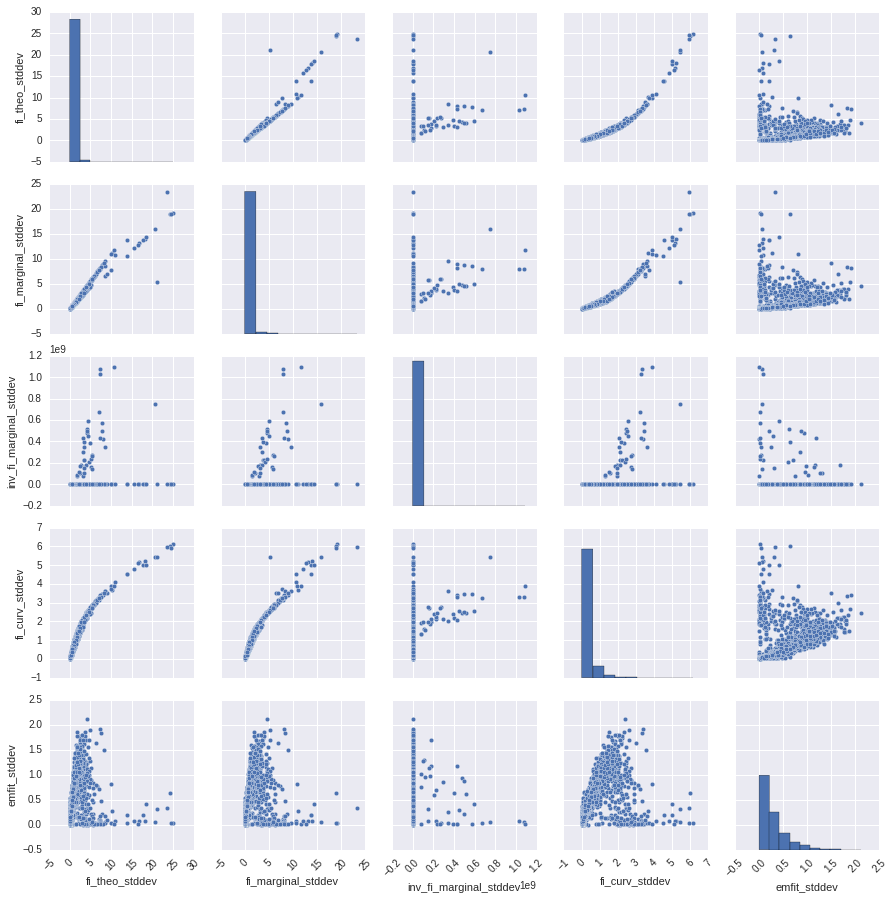

In [460]:
# Cross-correlation plots
g = sns.pairplot(df_fits_filtered,
             vars=['fi_theo_stddev', 'fi_marginal_stddev', 'inv_fi_marginal_stddev', 
                   'fi_curv_stddev', 'emfit_stddev'],
            )
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)


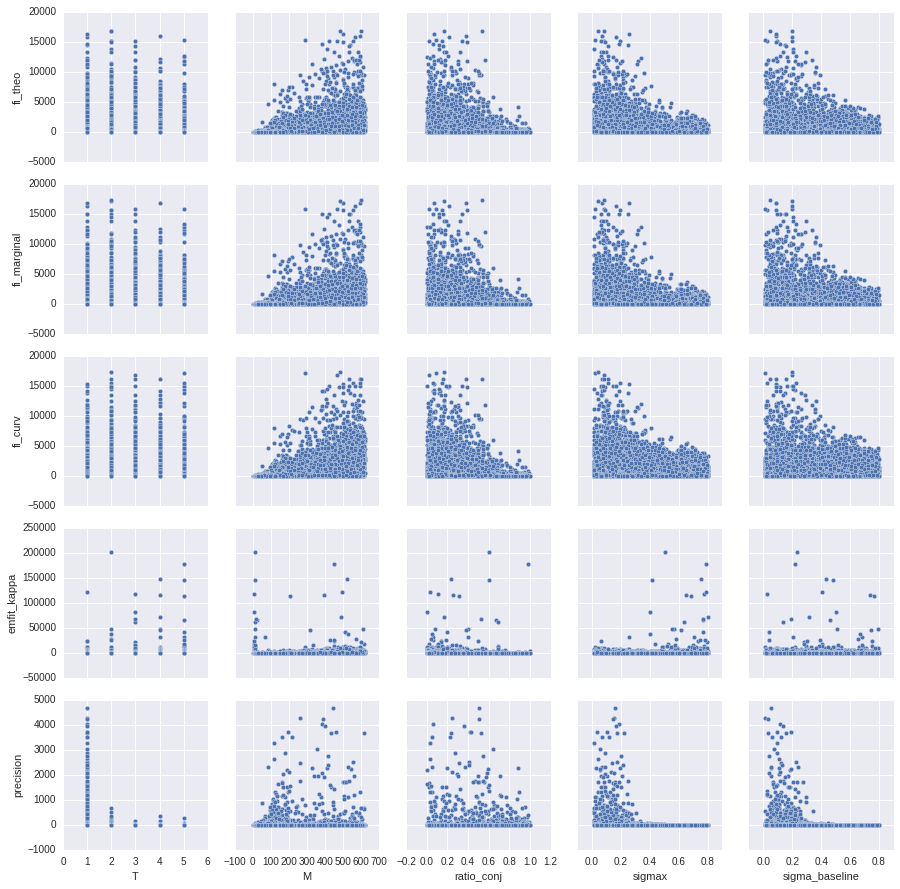

In [461]:
# Check parameters effects
sns.pairplot(df_fits_filtered,
             x_vars=parameter_names_sorted,
             y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa', 'precision']
            )

In [462]:
# for T, subdf in df_fits_filtered.groupby('T'):
#     g = sns.pairplot(subdf,
#                  x_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                  y_vars=['fi_theo', 'fi_marginal', 'fi_curv', 'emfit_kappa'],
#                 )
#     g.fig.suptitle("T : %d "% T, fontsize=30)
#     for ax in g.axes.flat:  
#         plt.setp(ax.get_xticklabels(), rotation=45)

## Quantize parameters

In [463]:
nQuantiles = 10
parameters = ['M', 'ratio_conj', 'sigmax', 'sigma_baseline']

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, param_name + "_qi"] = param_factored
    
    return df, param_qbins

df_quantized, param_qbins = df_add_quantize_parameters(df_fits_filtered, parameters, nQuantiles)

In [464]:
def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

### trying quantized Dataframes

In [465]:
df_lownoise = filter_quantized_param(filter_dataframe(df_quantized, dict(T=1)), 
                                     dict(sigmax=0.15, sigma_baseline=0.1), 
                                     param_qbins
                                    )

In [466]:
df_lownoise.describe()

,precision,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,fi_marginal_stddev,inv_fi_marginal,...,emfit_stddev,T,M,ratio_conj,sigmax,sigma_baseline,M_qi,ratio_conj_qi,sigmax_qi,sigma_baseline_qi
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,...,39.000000,39.0,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.0,39.0
mean,516.142950,1100.256455,0.149215,1080.537911,0.152974,1080.537911,0.152974,1109.200634,0.158353,0.048618,...,0.157464,1.0,122.179487,0.416166,0.132321,0.128654,3.205128,4.000000,1.0,1.0
std,644.588556,1333.428382,0.227556,1316.197279,0.246457,1316.197279,0.246457,1353.042645,0.272139,0.174554,...,0.251392,0.0,96.931303,0.285223,0.020413,0.017994,2.319023,2.919986,0.0,0.0
min,0.619839,2.059513,0.020287,1.460957,0.019675,1.460957,0.019675,1.157181,0.019417,0.000189,...,0.020090,1.0,7.000000,0.000000,0.102882,0.097985,0.000000,0.000000,1.0,1.0
25%,40.613908,92.182336,0.033382,89.886499,0.032784,89.886499,0.032784,87.622568,0.032309,0.000522,...,0.034490,1.0,61.000000,0.148116,0.111131,0.115989,1.000000,1.000000,1.0,1.0
50%,199.326441,471.458798,0.066272,459.654640,0.065966,459.654640,0.065966,468.375422,0.065346,0.002135,...,0.070830,1.0,122.000000,0.400000,0.129172,0.125768,3.000000,4.000000,1.0,1.0
75%,840.656680,1891.611505,0.149798,1862.931234,0.149268,1862.931234,0.149268,1917.317389,0.151154,0.011427,...,0.156167,1.0,152.000000,0.685131,0.150948,0.146180,4.500000,7.000000,1.0,1.0
max,2477.599710,5109.263401,1.069091,5168.261317,1.181250,5168.261317,1.181250,5304.520080,1.314663,0.864169,...,1.245158,1.0,558.000000,0.968000,0.164388,0.159222,9.000000,9.000000,1.0,1.0


In [467]:
df_lownoise[['fi_theo_stddev', 'emfit_stddev', 'emfit_target', 'M', 'ratio_conj']].corr()

,fi_theo_stddev,emfit_stddev,emfit_target,M,ratio_conj
fi_theo_stddev,1.000000,0.998965,-0.760270,-0.439944,0.035291
emfit_stddev,0.998965,1.000000,-0.731433,-0.441778,0.036642
emfit_target,-0.760270,-0.731433,1.000000,0.234618,0.040277
M,-0.439944,-0.441778,0.234618,1.000000,0.218897
ratio_conj,0.035291,0.036642,0.040277,0.218897,1.000000


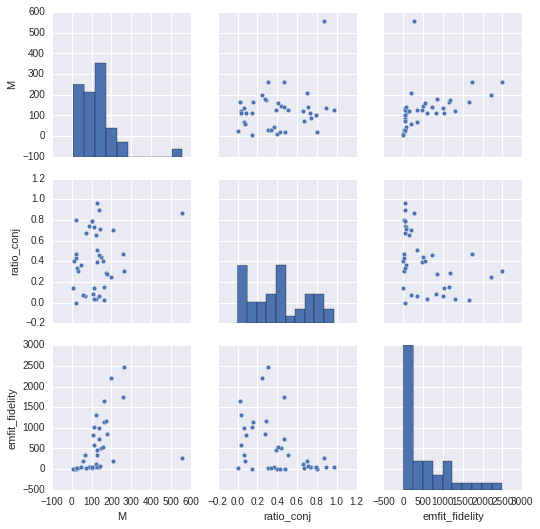

In [468]:
sns.pairplot(df_lownoise,
             vars=['M', 'ratio_conj', 'emfit_stddev']
            )

# ==> Not enough datapoints...

Use 2try instead, fixing sigmax and sigma_baseline